In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

# path = "drive/MyDrive/645-project-data/" # Google Drive path
path = "data/"  # Local path

In [2]:
# Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Check RAM
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Apr  4 02:23:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Importing required libraries

import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd 
from keras import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [4]:
# Upload train.zip to local Colab storage before running this cell
# Move data to a new directory
!mkdir data

In [5]:
%%capture
!unzip train.zip -d data/train

In [ ]:
# Read labels.csv file
labels = pd.read_csv(path + "labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Describe data
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


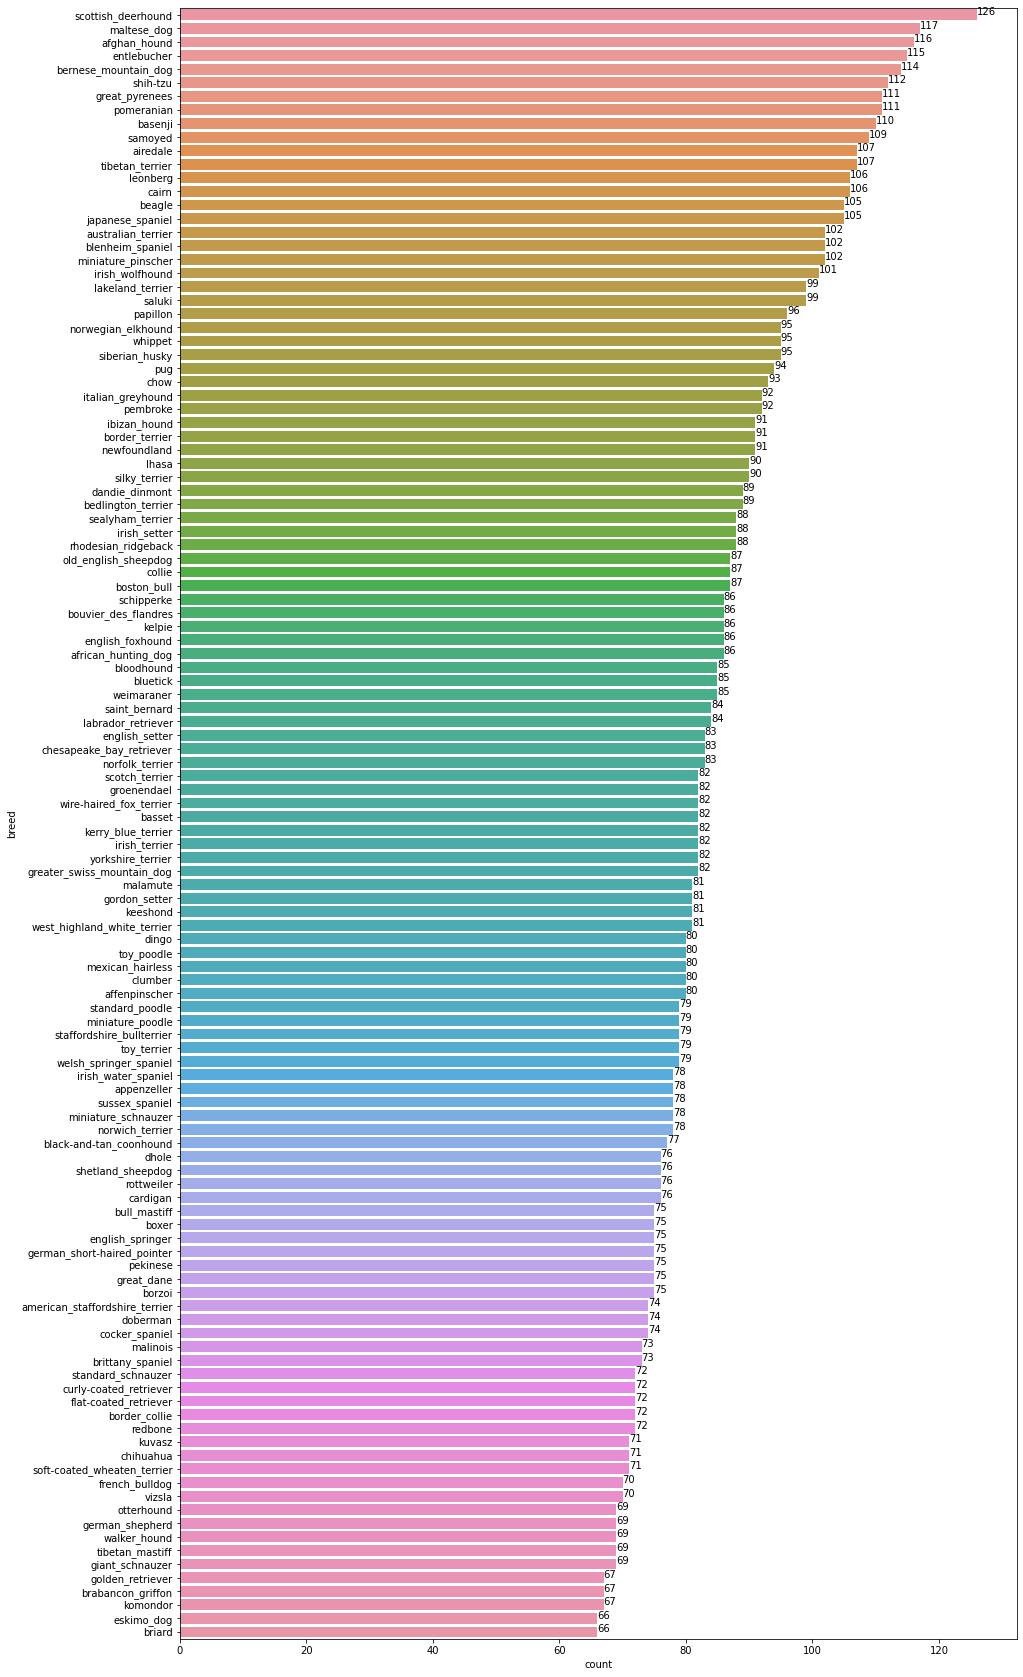

In [ ]:
# Function to show bar length
def barw(ax):  
    for p in ax.patches:
        val = p.get_width()                   # Height of the bar
        x = p.get_x() + p.get_width()         # x- position 
        y = p.get_y() + p.get_height() / 2    # y-position
        ax.annotate(round(val, 2),(x, y))
        
# Visualize top dog breeds
plt.figure(figsize=(15, 30))
ax0 = sns.countplot(y=labels['breed'] ,order=labels['breed'].value_counts().index)
barw(ax0)
plt.show()

In [ ]:
# Total unique breeds
labels['breed'].nunique()

120

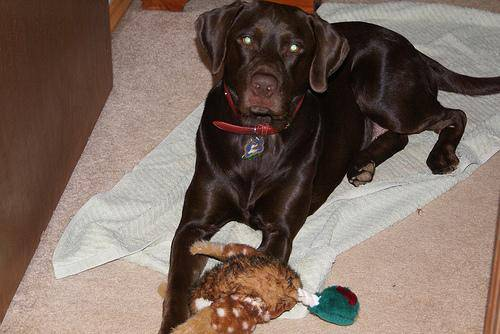

In [ ]:
# Check one image
from IPython.display import display, Image
Image("./data/train/43572ba7edf772a95f539e57afd9eb43.jpg")

In [ ]:
import os

# Verify number of labels match the number of images
if len(os.listdir('./data/train/')) == len(labels['id']):
    print('Number of file matches number of actual images!')
else:
    print('Number of file does not matches number of actual images!')

Number of file matches number of actual images!


In [ ]:
# Create list of alphabetically sorted labels
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))

# Map each label string to an integer label
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [ ]:
input_shape = (224, 224, 3)

def images_to_array(directory, label_dataframe, target_size = input_shape):    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8)
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        images[ix]=img
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return images,y

In [ ]:
import time 
t = time.time()

X, y = images_to_array('./data/train', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds: 33.75991630554199


In [ ]:
# View some select images and associated breeds
n = 25
plt.figure(figsize=(20,20))

for i in range(n):
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32'))

In [ ]:
# Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5, verbose=1)

# Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Hyperparameters
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Function to extract features from the dataset by a given the models
img_size = (224, 224, 3)

def get_features(model_name, layer_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    model_name.get_layer(layer_name)
    base_model = Lambda(model_name)(preprocessor)
    # avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=base_model)
    
    # Extract features
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [ ]:
# Import best VGG-16 model
vgg16_model = tf.keras.models.load_model("./models/dog_breed_classifier_vgg16.h5")

In [ ]:
# Extract features from VGG16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
vgg16_preprocessor = preprocess_input
vgg16_features = get_features(vgg16_model, 'vgg16', preprocess_input, img_size, X)

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
  <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
  <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
  <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32>
  <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32>
  <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'block3_conv3/kernel:0' shape

In [ ]:
# Import best resnet model
resnet50_model = tf.keras.models.load_model("./models/dog_breed_classifier_resnet50.h5")

In [ ]:
# Extract features from ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
resnet50_preprocessor = preprocess_input
resnet50_features = get_features(resnet50_model, 'resnet50', preprocess_input, img_size, X)

The following Variables were used a Lambda layer's call (lambda_4), but
are not present in its tracked objects:
  <tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
  <tf.Variable 'conv1_conv/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1_bn/beta:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_1_conv/kernel:0' shape=(1, 1, 64, 64) dtype=float32>
  <tf.Variable 'conv2_block1_1_conv/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_1_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_1_bn/beta:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_2_conv/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
  <tf.Variable 'conv2_block1_2_conv/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_2_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_2_bn/beta:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_0_conv/kernel:0' sha

In [ ]:
final_features = np.concatenate([
                 vgg16_features,
                 resnet50_features,                
    ], axis=-1) #axis=-1 to concatinate horizontally                                 

print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 240)


In [ ]:
#Prepare Deep net

model = Sequential()
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
64/64 [==============================] - 2s 7ms/step - loss: 4.7570 - accuracy: 0.0475 - val_loss: 4.7026 - val_accuracy: 0.1531 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 0s 4ms/step - loss: 4.6654 - accuracy: 0.1142 - val_loss: 4.6110 - val_accuracy: 0.2861 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 0s 4ms/step - loss: 4.5772 - accuracy: 0.1672 - val_loss: 4.5224 - val_accuracy: 0.3716 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 0s 4ms/step - loss: 4.4898 - accuracy: 0.2112 - val_loss: 4.4359 - val_accuracy: 0.4797 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 0s 4ms/step - loss: 4.4073 - accuracy: 0.2501 - val_loss: 4.3514 - val_accuracy: 0.5399 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 0s 4ms/step - loss: 4.3261 - accuracy: 0.2814 - val_loss: 4.2676 - val_accuracy: 0.5790 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 0s 4ms/step - loss: 4.2410 - a